In [1]:
import csv
from collections import defaultdict
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def bias_category(bias_score):
    bias_score = int(bias_score)
    if bias_score < -80:
        category = "-100 to -80"
    elif bias_score < -60:
        category = "-80 to -60"
    elif bias_score < -40:
        category = "-60 to -40"
    elif bias_score < -20:
        category = "-40 to -20"
    elif bias_score < 0:
        category = "-20 to 0"
    elif bias_score < 20:
        category = "0 to 20"
    elif bias_score < 40:
        category = "20 to 40"
    elif bias_score < 60:
        category = "40 to 60"
    elif bias_score < 80:
        category = "60 to 80"
    else:
        category = "80 to 100"
    return category


def same_sign(a,b):
    "Return True if both numbers are positive/negative, false otherwise."
    if (a > 0 and b > 0) or (a < 0 and b < 0):
        return 1
    else:
        return 0


def aggregate(data):
    "Aggregate the data."
    results = dict(male=defaultdict(list), female=defaultdict(list))
    for result in data:
        bias = int(result['bias'])
        outcome = float(result['subject_preference'])

        # Skip if bias is exactly zero.
        if bias == '0':
            continue

        category = bias_category(bias)
        expected = same_sign(bias,outcome)

        if result['subject_gender'] == '1':
            results['male'][category].append(expected)
        else:
            results['female'][category].append(expected)

    return results


def get_rows(data):
    "Get rows based on data."
    rows = []
    aggregated = aggregate(data)
    for gender, results in aggregated.items():
        for category, outcomes in results.items():
            row = dict(gender=gender, category=category, score= int((sum(outcomes)/len(outcomes))*100))
            rows.append(row)
    return rows

In [3]:
with open("../data/experiment1_surprisals.csv") as f:
    reader = csv.DictReader(f)
    data = list(reader)

rows = get_rows(data)
df = pd.DataFrame(rows)

# Sort the data:
order = reversed(["-100 to -80", "-80 to -60", "-60 to -40", "-40 to -20", "-20 to 0", "0 to 20", "20 to 40", "40 to 60", "60 to 80", "80 to 100"])
df['category'] = pd.Categorical(df['category'], order)
df.sort_values("category")

# Pivot the table:
df = df.pivot(index='category', columns='gender')



In [4]:
df

score     
gender      female male
category               
80 to 100       49   75
60 to 80        45   77
40 to 60        47   74
20 to 40        53   66
0 to 20         43   57
-20 to 0        59   47
-40 to -20      68   65
-60 to -40      69   64
-80 to -60      67   60
-100 to -80     80   80

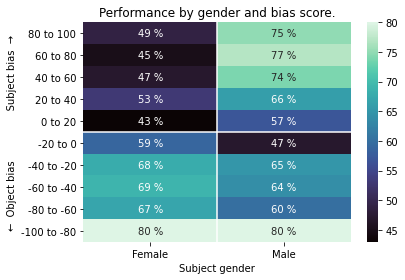

In [5]:
palette = sns.color_palette("mako", as_cmap=True)
g = sns.heatmap(df,annot=True,cmap=palette)
yticks = plt.yticks(rotation=0)

g.set_xticklabels(['Female','Male'])

for t in g.texts: t.set_text(t.get_text() + " %")

plt.hlines(y=5, xmin=-5, xmax=2, color='w', linestyle='-')
plt.vlines(x=1, ymin=0, ymax=10, color='w', linestyle='-')

plt.xlabel("Subject gender")
plt.ylabel("←  Object bias                Subject bias  →")
plt.title("Performance by gender and bias score.")
plt.tight_layout()

plt.savefig("../figures/performance.pdf")
